In [17]:
cd((@__DIR__) * raw"\..")
include("../table_reader.jl")
include("../utils/Missing_values.jl")

truncate_MV (generic function with 1 method)

In [18]:
series=extract_series("TX_STAID000031.txt",plot=false)
series=truncate_MV(series,"TX")
years=unique(Dates.year.(series.DATE))

include("../utils/Simulation.jl")
Days_list=GatherYearScenario(series[!,2],series.DATE)
avg_day=mean.(Days_list)
max_day=maximum.(Days_list)
df_month = @chain series begin
    @transform(:TEMP = series[!,2]) #Give a common name for TX, TN, etc...
    @transform(:MONTH = month.(:DATE)) #add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:TEMP), :MONTHLY_STD = std(:TEMP), :MONTHLY_MAX = maximum(:TEMP)) # grouby MONTH + takes the mean/std in each category 
end

#Imputing missing values
# include("utils/Missing_values.jl")
# ImputeMissingValues!(series[!,2],series.DATE)
# N=length(series[!,2])

12×4 DataFrame
 Row │ MONTH  MONTHLY_MEAN  MONTHLY_STD  MONTHLY_MAX 
     │ Int64  Float64       Float64      Float64     
─────┼───────────────────────────────────────────────
   1 │     1       1.17685     0.332309         2.12
   2 │     2       1.28727     0.331852         2.27
   3 │     3       1.54382     0.311683         2.61
   4 │     4       1.79017     0.303244         2.62
   5 │     5       2.19996     0.325811         3.19
   6 │     6       2.54889     0.309155         3.6
   7 │     7       2.85561     0.300014         4.06
   8 │     8       2.80813     0.278482         3.64
   9 │     9       2.47622     0.280431         3.3
  10 │    10       2.06394     0.312442         3.09
  11 │    11       1.52238     0.335048         2.43
  12 │    12       1.23495     0.328123         2.31

In [19]:
series.DATE[series.DATE .> Date(1960),:]

15795×1 Matrix{Date}:
 1960-01-02
 1960-01-03
 1960-01-04
 1960-01-05
 1960-01-06
 1960-01-07
 1960-01-08
 1960-01-09
 1960-01-10
 1960-01-11
 ⋮
 2003-03-23
 2003-03-24
 2003-03-25
 2003-03-26
 2003-03-27
 2003-03-28
 2003-03-29
 2003-03-30
 2003-03-31

## I. Series filtered by removing a trigonometric periodicity

In [20]:
include("../utils/periodicity.jl")
trigo_function=fitted_periodicity_fonc(series[!,2],series.DATE,OrderTrig=3)
periodicity=trigo_function.(series.DATE)
x=series[!,2]-periodicity
period=trigo_function.(Date(0):Date(1)-Day(1))

366-element Vector{Float64}:
 1.152658587334172
 1.1510176520132789
 1.149669872596134
 1.148612331723129
 1.1478418982679353
 1.1473552329151242
 1.147148794128307
 1.1472188444991152
 1.1475614574663708
 1.1481725243938423
 ⋮
 1.1776462805766805
 1.1735074502813172
 1.1696771035088889
 1.1661542438316908
 1.1629376308469186
 1.160025782298712
 1.1574169766316935
 1.15510925597479
 1.1531004295530736

## Segmenting the dataset by month

In [21]:
include("../utils/Separation.jl")
Monthly_date=MonthlySeparateDates(series.DATE)
Monthly_temp=MonthlySeparateX(x,series.DATE)

12-element Vector{Vector{AbstractVector}}:
 [[0.12734141266582832, 0.24898234798672125, 0.35033012740386593, 0.06138766827687103, 0.1521581017320648, 0.29264476708487597, 0.2628512058716932, -0.14721884449911515, -0.3575614574663708, -0.06817252439384225  …  -0.5147355765658704, -0.5783946550498587, -0.2522502423929651, 0.02370345355060488, -0.2905277422825704, -0.06493798278415741, 0.10047859068357479, 0.09572783764501391, 0.0708156078911486, 0.08574773090532717], [0.3473414126658281, -0.12101765201327885, -0.199669872596134, -0.028612331723129047, -0.3378418982679352, -0.04735523291512411, 0.18285120587169312, 0.10278115550088485, -0.5275614574663707, -0.5481725243938422  …  0.33526442343412954, 0.5216053449501414, 0.3777497576070348, 0.013703453550605094, 0.1994722577174297, 0.06506201721584248, 0.2504785906835749, 0.09572783764501391, 0.0908156078911484, -0.09425226909467299], [0.2473414126658282, 0.4389823479867212, 0.430330127403866, 0.5513876682768712, 0.5721581017320647, 0.2126

## Autocorrelations

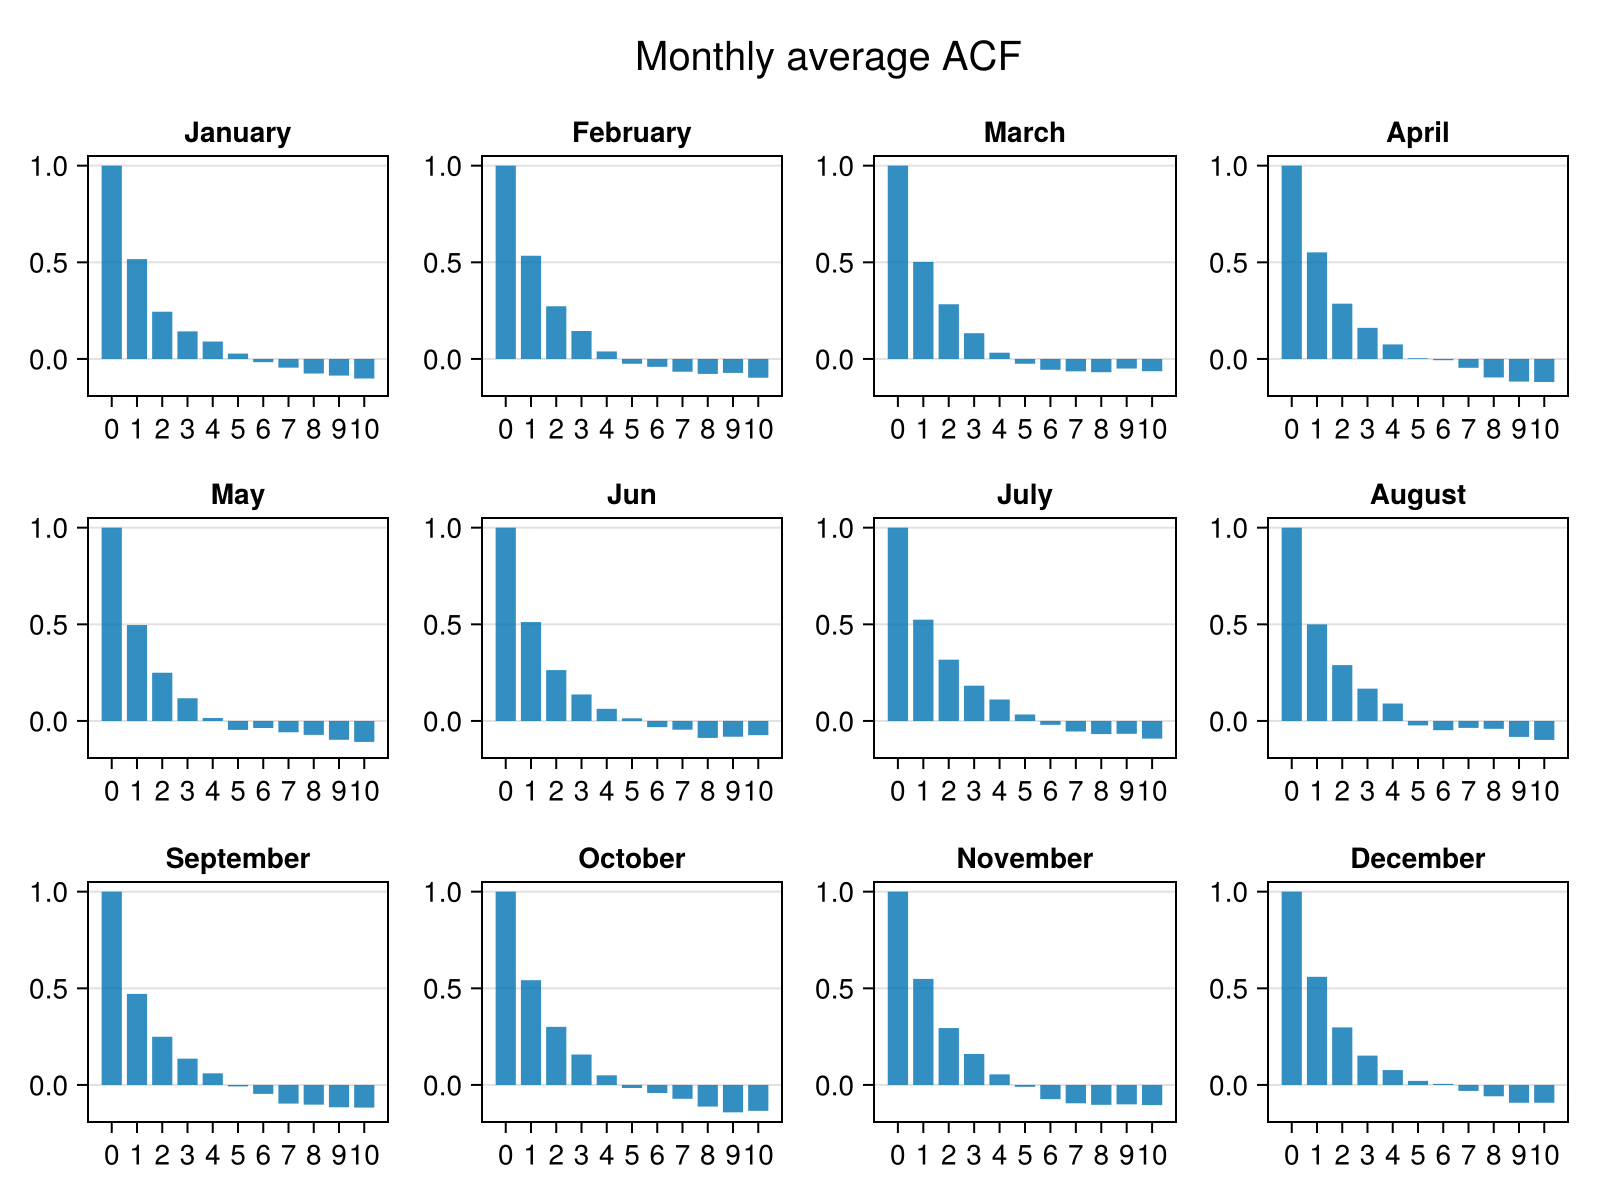

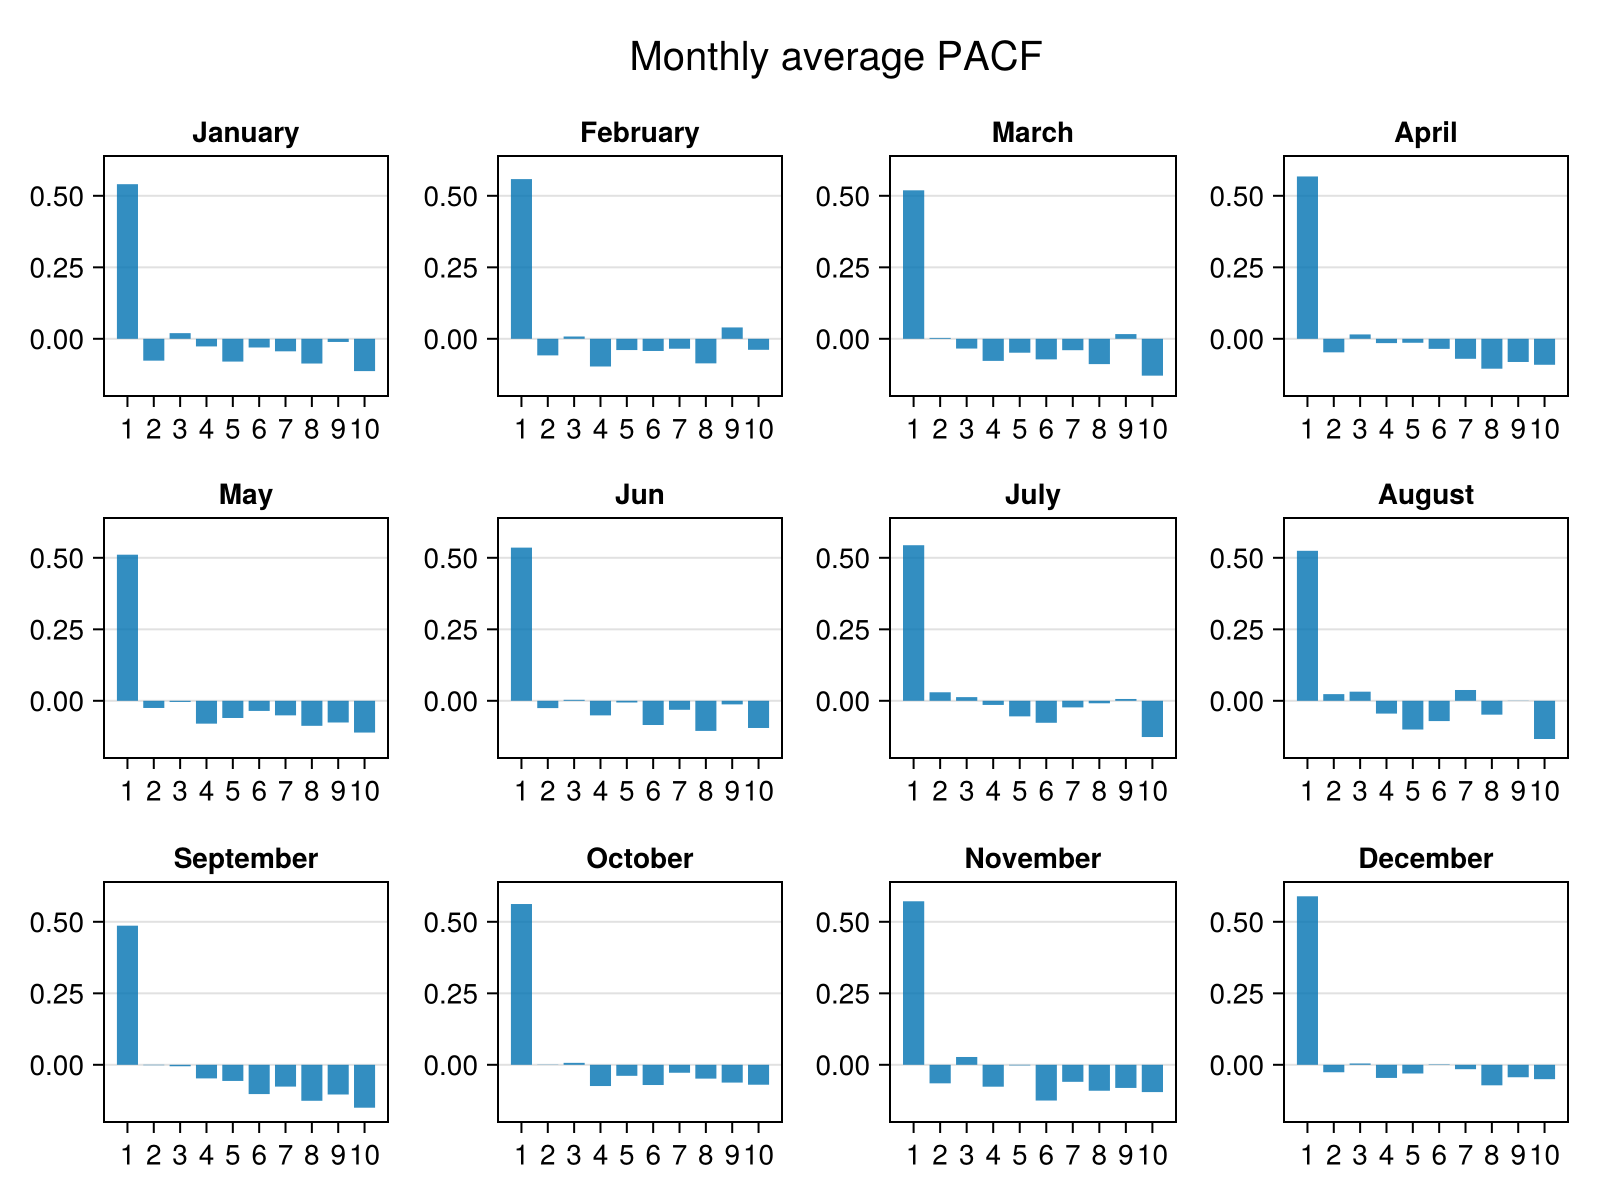

CairoMakie.Screen{IMAGE}


In [22]:
include("../utils/ACF_PACF.jl")
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

For each month, it still looks like an AR(1) model

# Estimation AR(1)

## Estimation

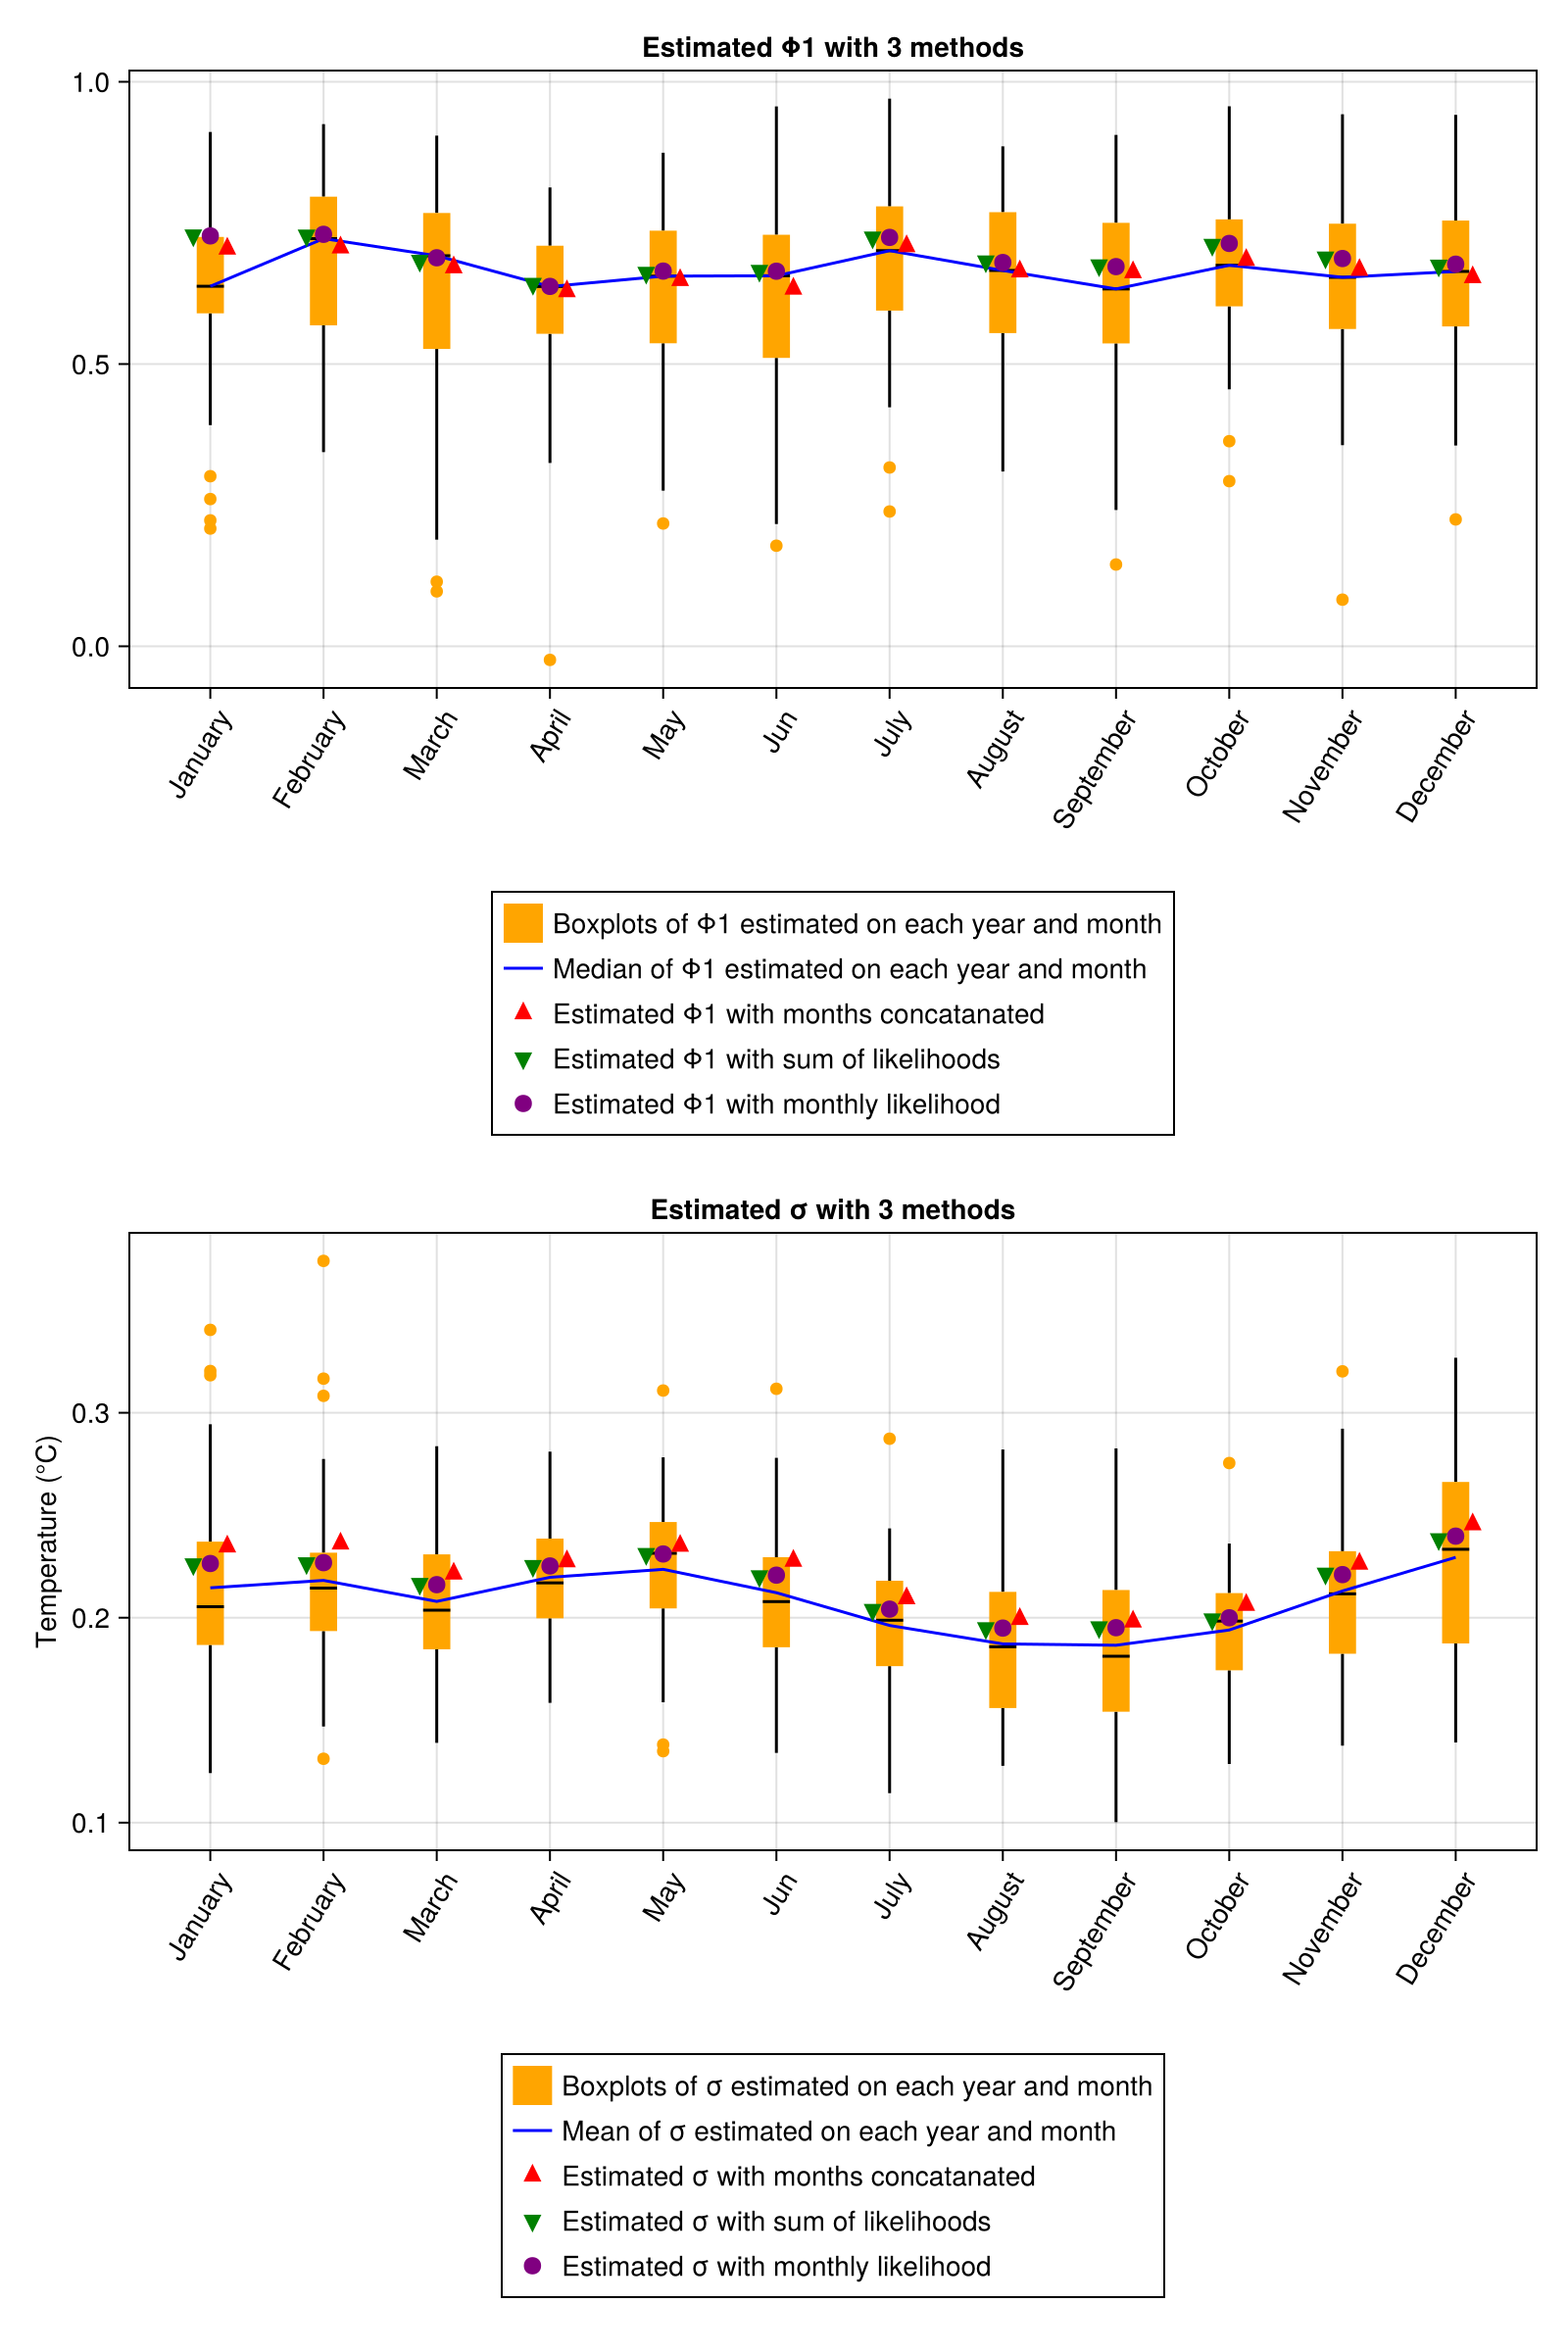

CairoMakie.Screen{IMAGE}


In [23]:
include(raw"..\utils\Estimation.jl")
Params, figure= AllEstimation(x, Date_vec=series.DATE, lineplot=true)
display(figure)

## Simulation

### With monthly likelihoods

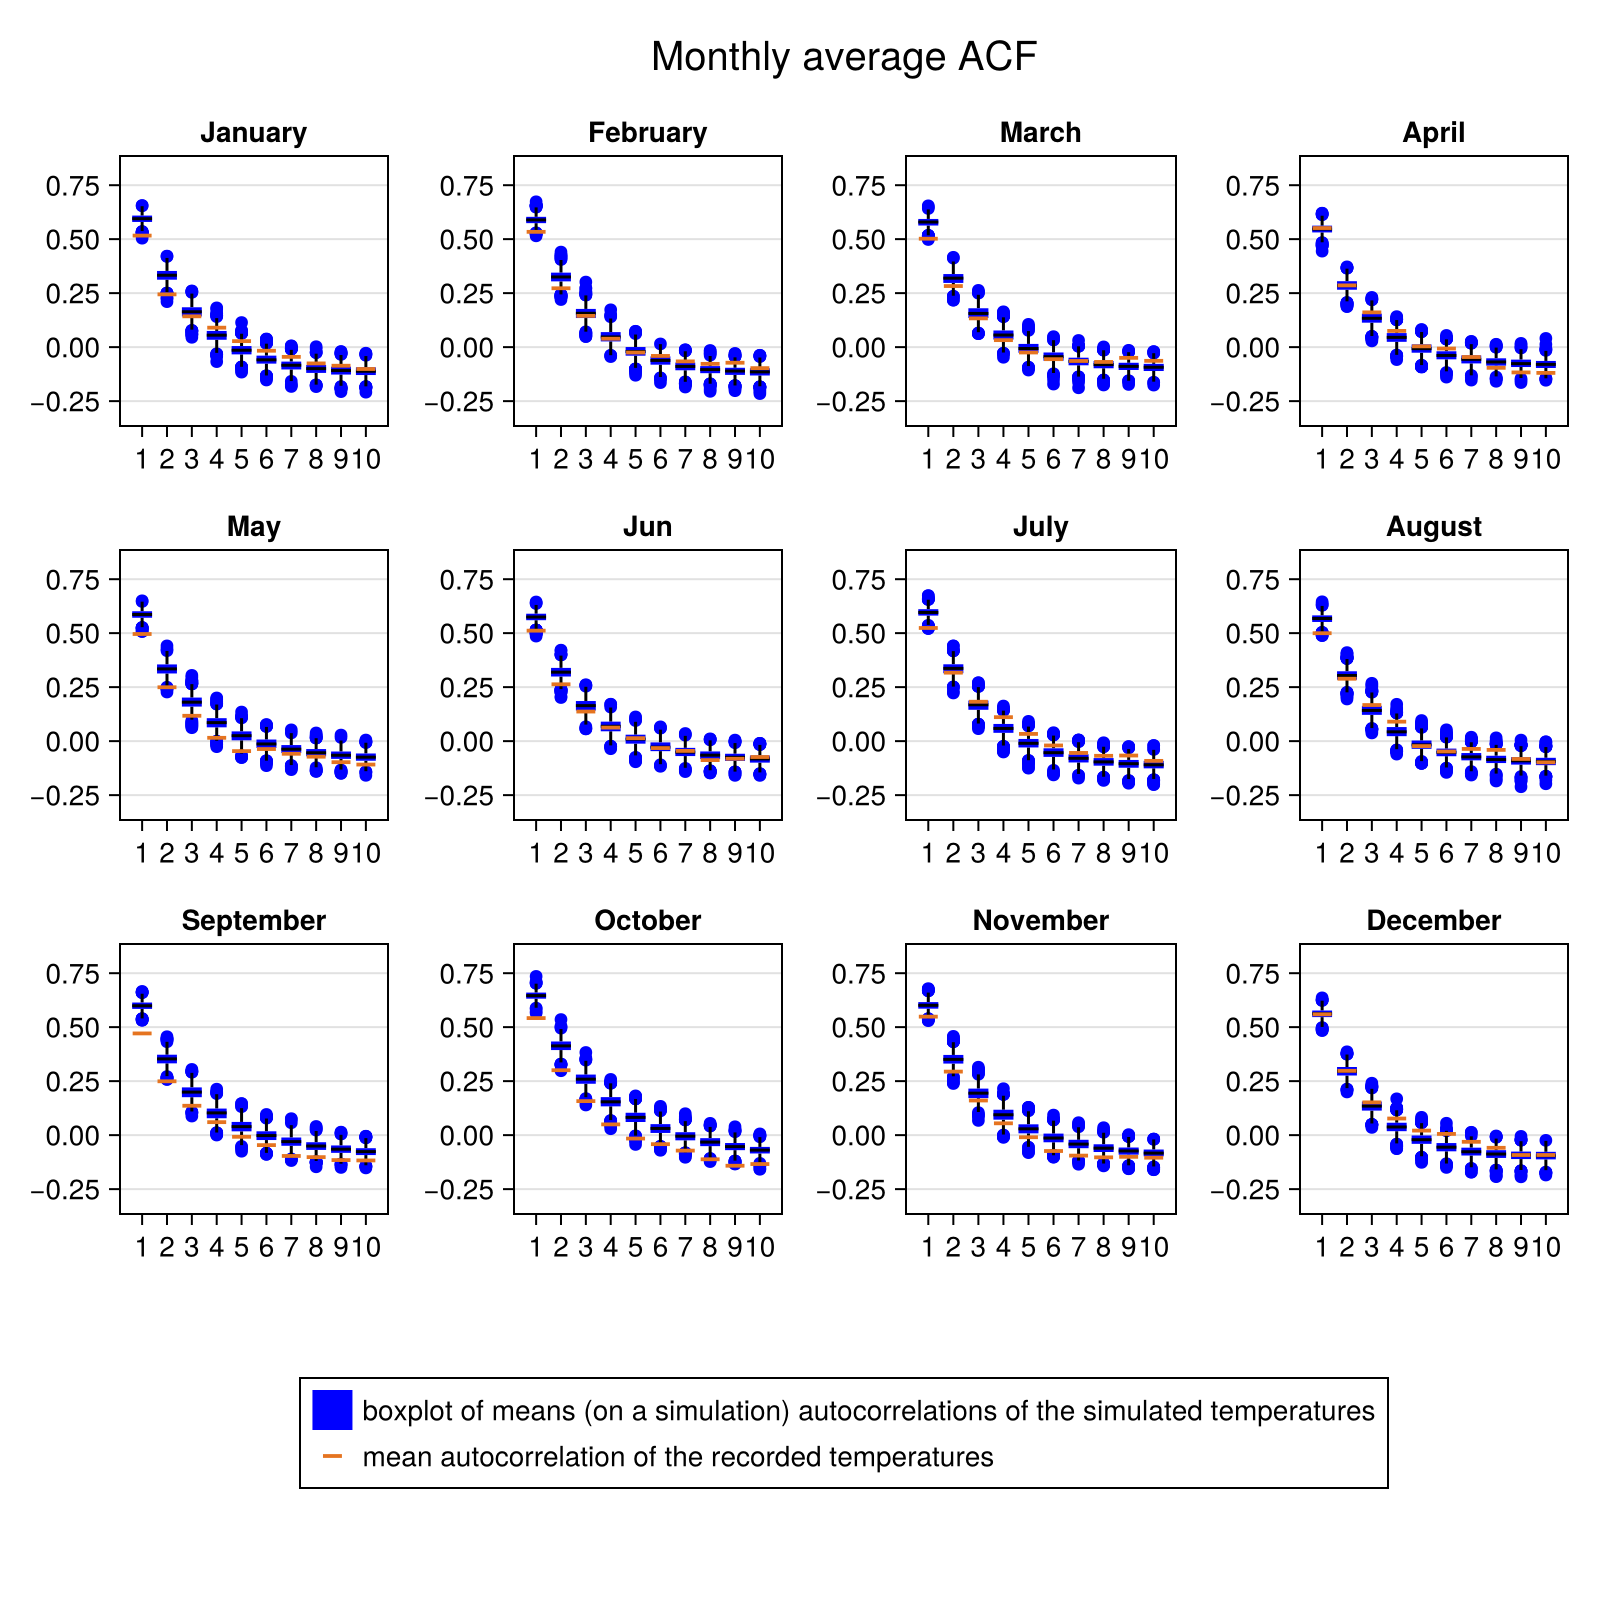

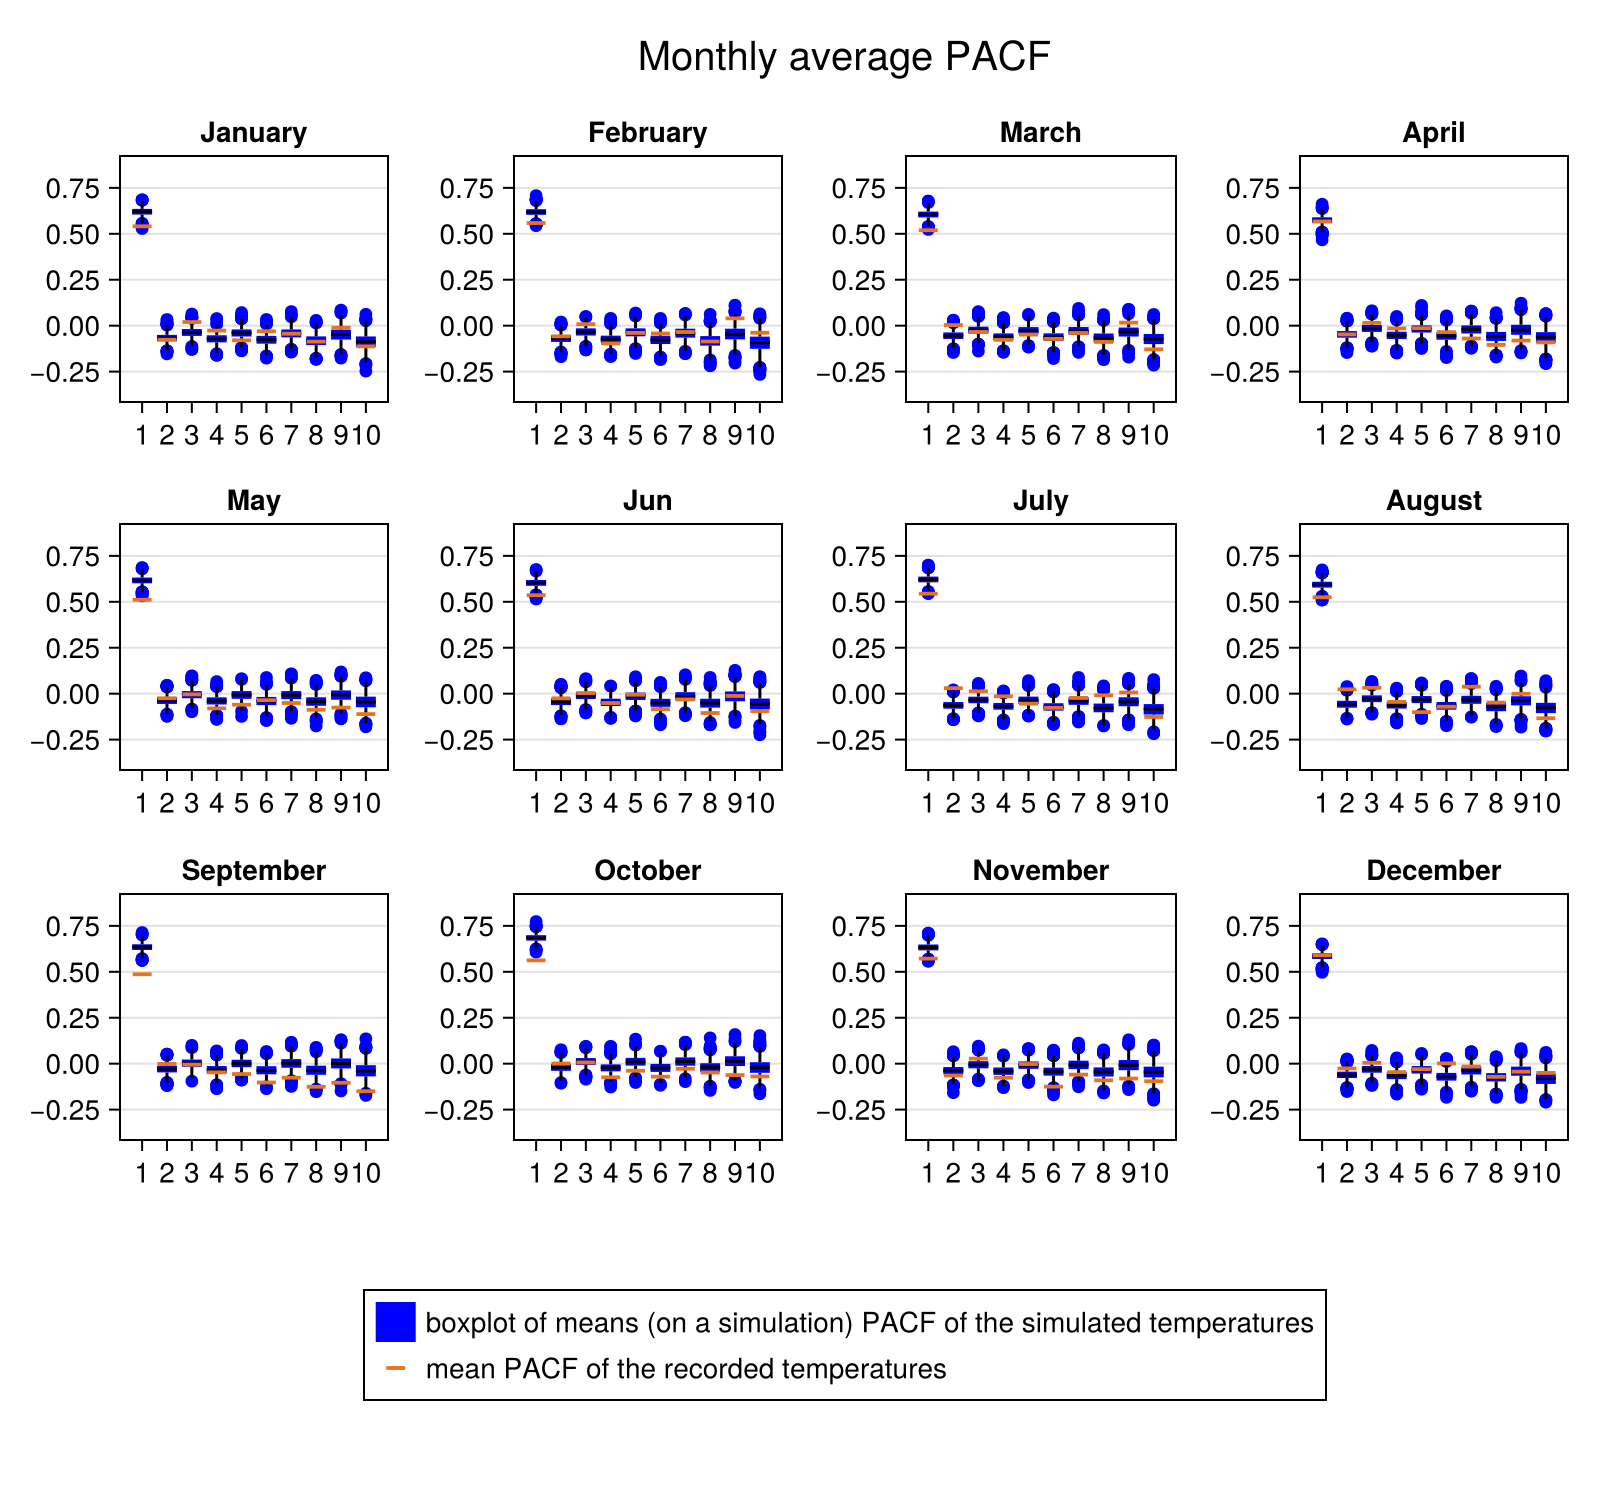

CairoMakie.Screen{IMAGE}


In [25]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"monthlyLL")
sample_ = SimulateScenarios(Monthly_temp[1][1][1],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=2000)
year_sample = GatherYearScenarios(sample_,series.DATE[1]:series.DATE[end])
# display(PlotYearCurves([period,mean.(year_sample)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
# display(PlotYearCurves([period,avg_day,max_day],
# ["Periodicity estimation","Average recorded temperatures","Maximum recorded temperatures","Simulated temperatures range","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
# "Average daily temperature during a year (centered)",
# [(minimum.(year_sample),maximum.(year_sample)),(quantile.(year_sample,0.25),quantile.(year_sample,0.75))],
# [("#009bff",0.2),("#009bff",0.5)],
# colors=["blue","orange","red"]
# ))
# display(PlotYearCurves([maximum.(year_sample) .- minimum.(year_sample) , quantile.(year_sample,0.75) .- quantile.(year_sample,0.25)],
# ["Simulated temperatures range" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
# "Simulated temperatures interquartile range"
# ))
# display.(WrapPlotMonthlyStats(df_month, sample_, series.DATE[1]:series.DATE[end]))
display(Plot_Sample_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))
display(Plot_Sample_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

In [26]:
mean(Error_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

0.04460745371114298

In [ ]:
MPACF=Error_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp)
display(mean(MPACF[1,:]))
display(mean(MPACF[2,:]))

# Estimation AR(2)

## Estimation

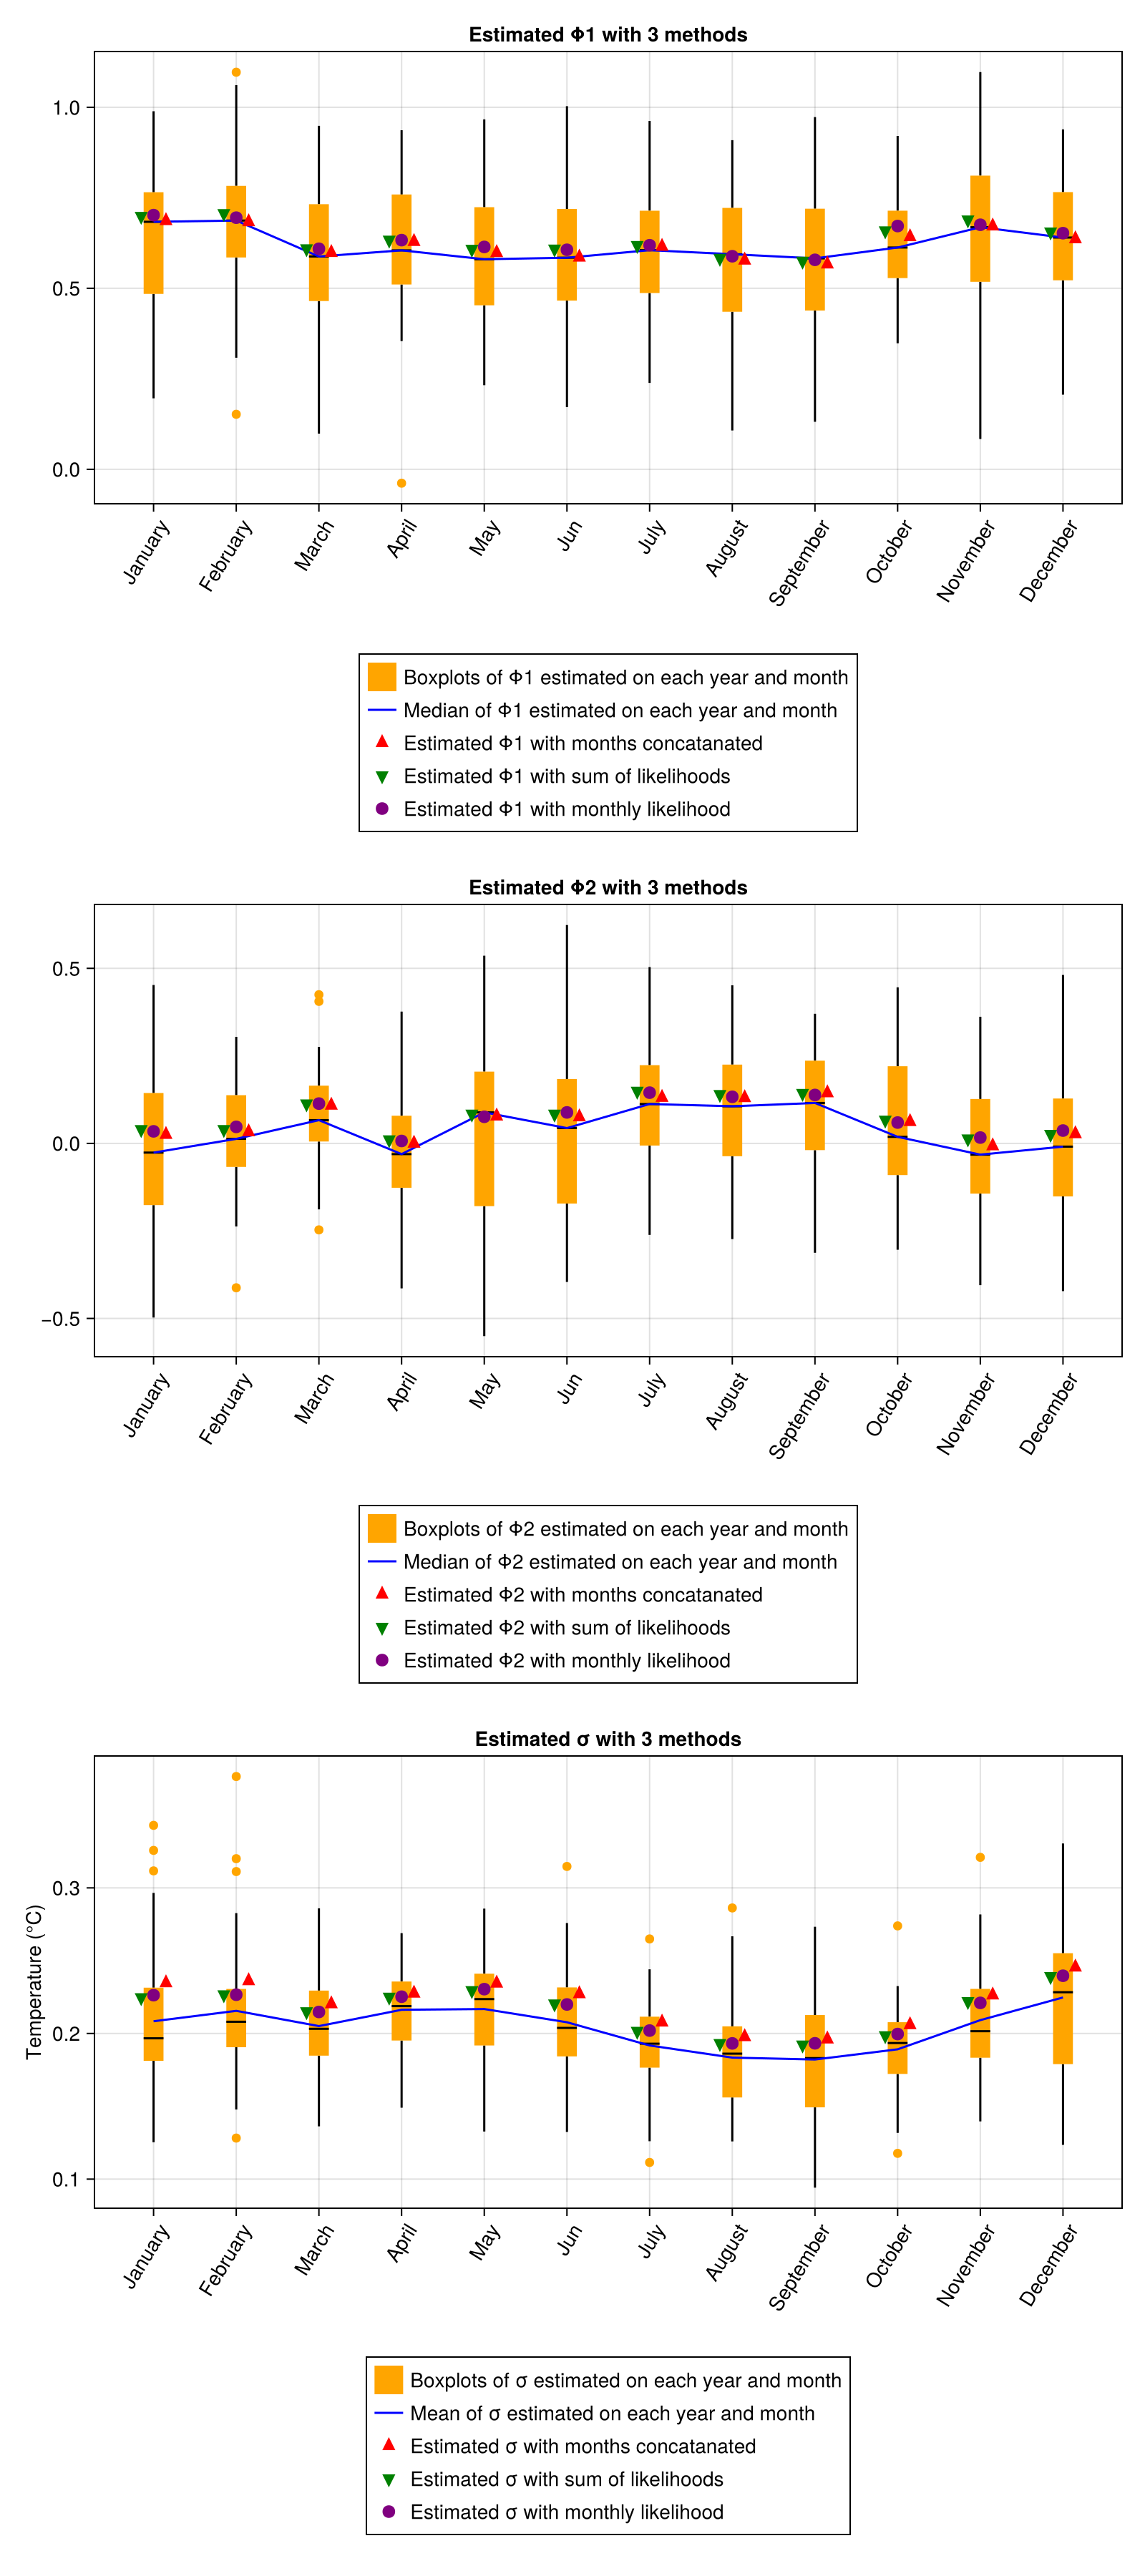

CairoMakie.Screen{IMAGE}


In [28]:
include("../utils/Estimation.jl")
Params, figure= AllEstimation(x, 2, Date_vec=series.DATE, lineplot=true)
display(figure)

## Simulation

### With monthly likelihoods

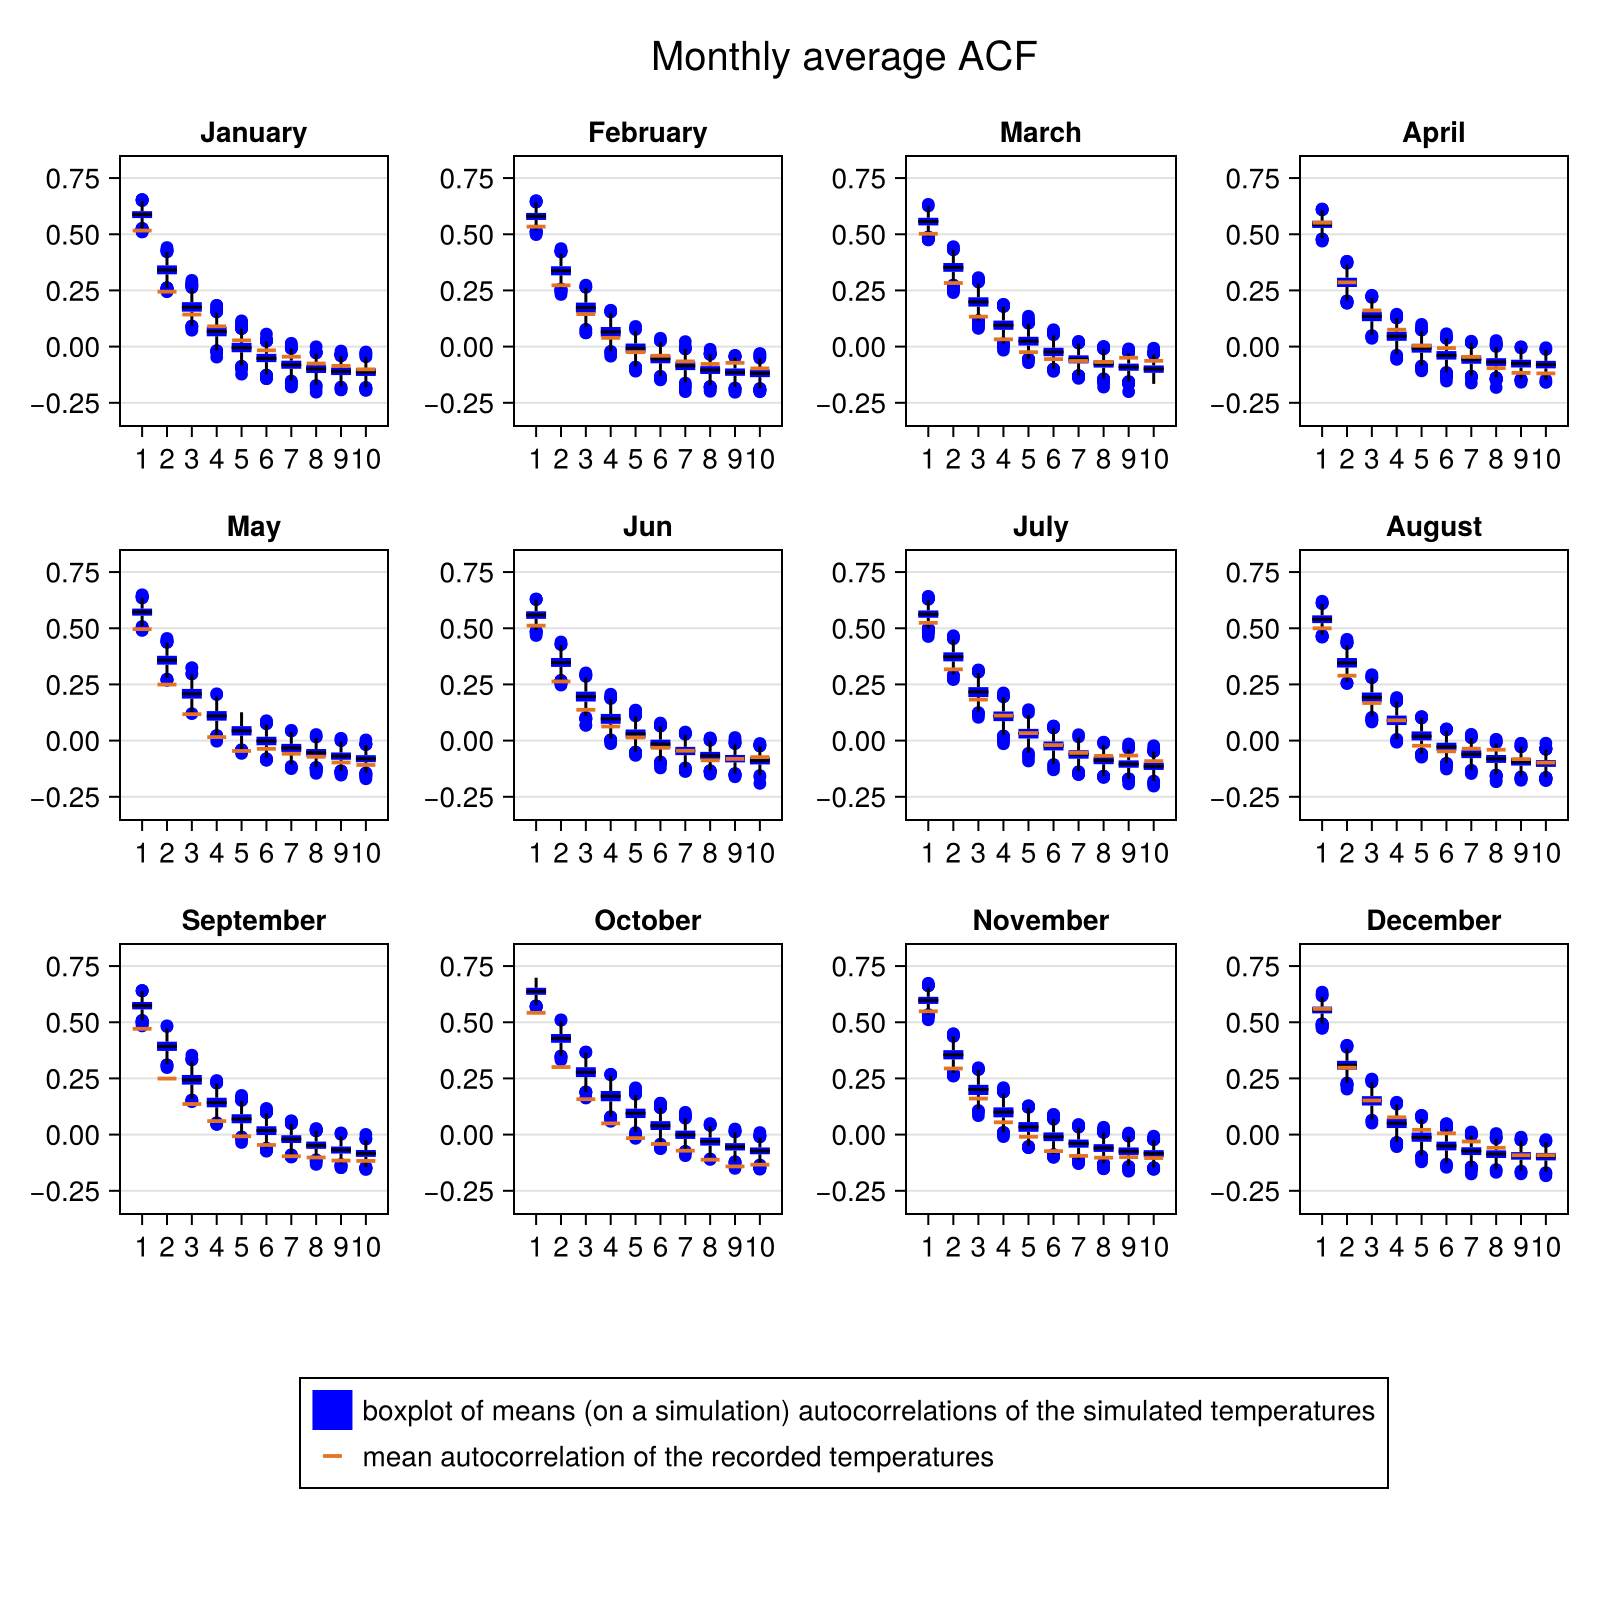

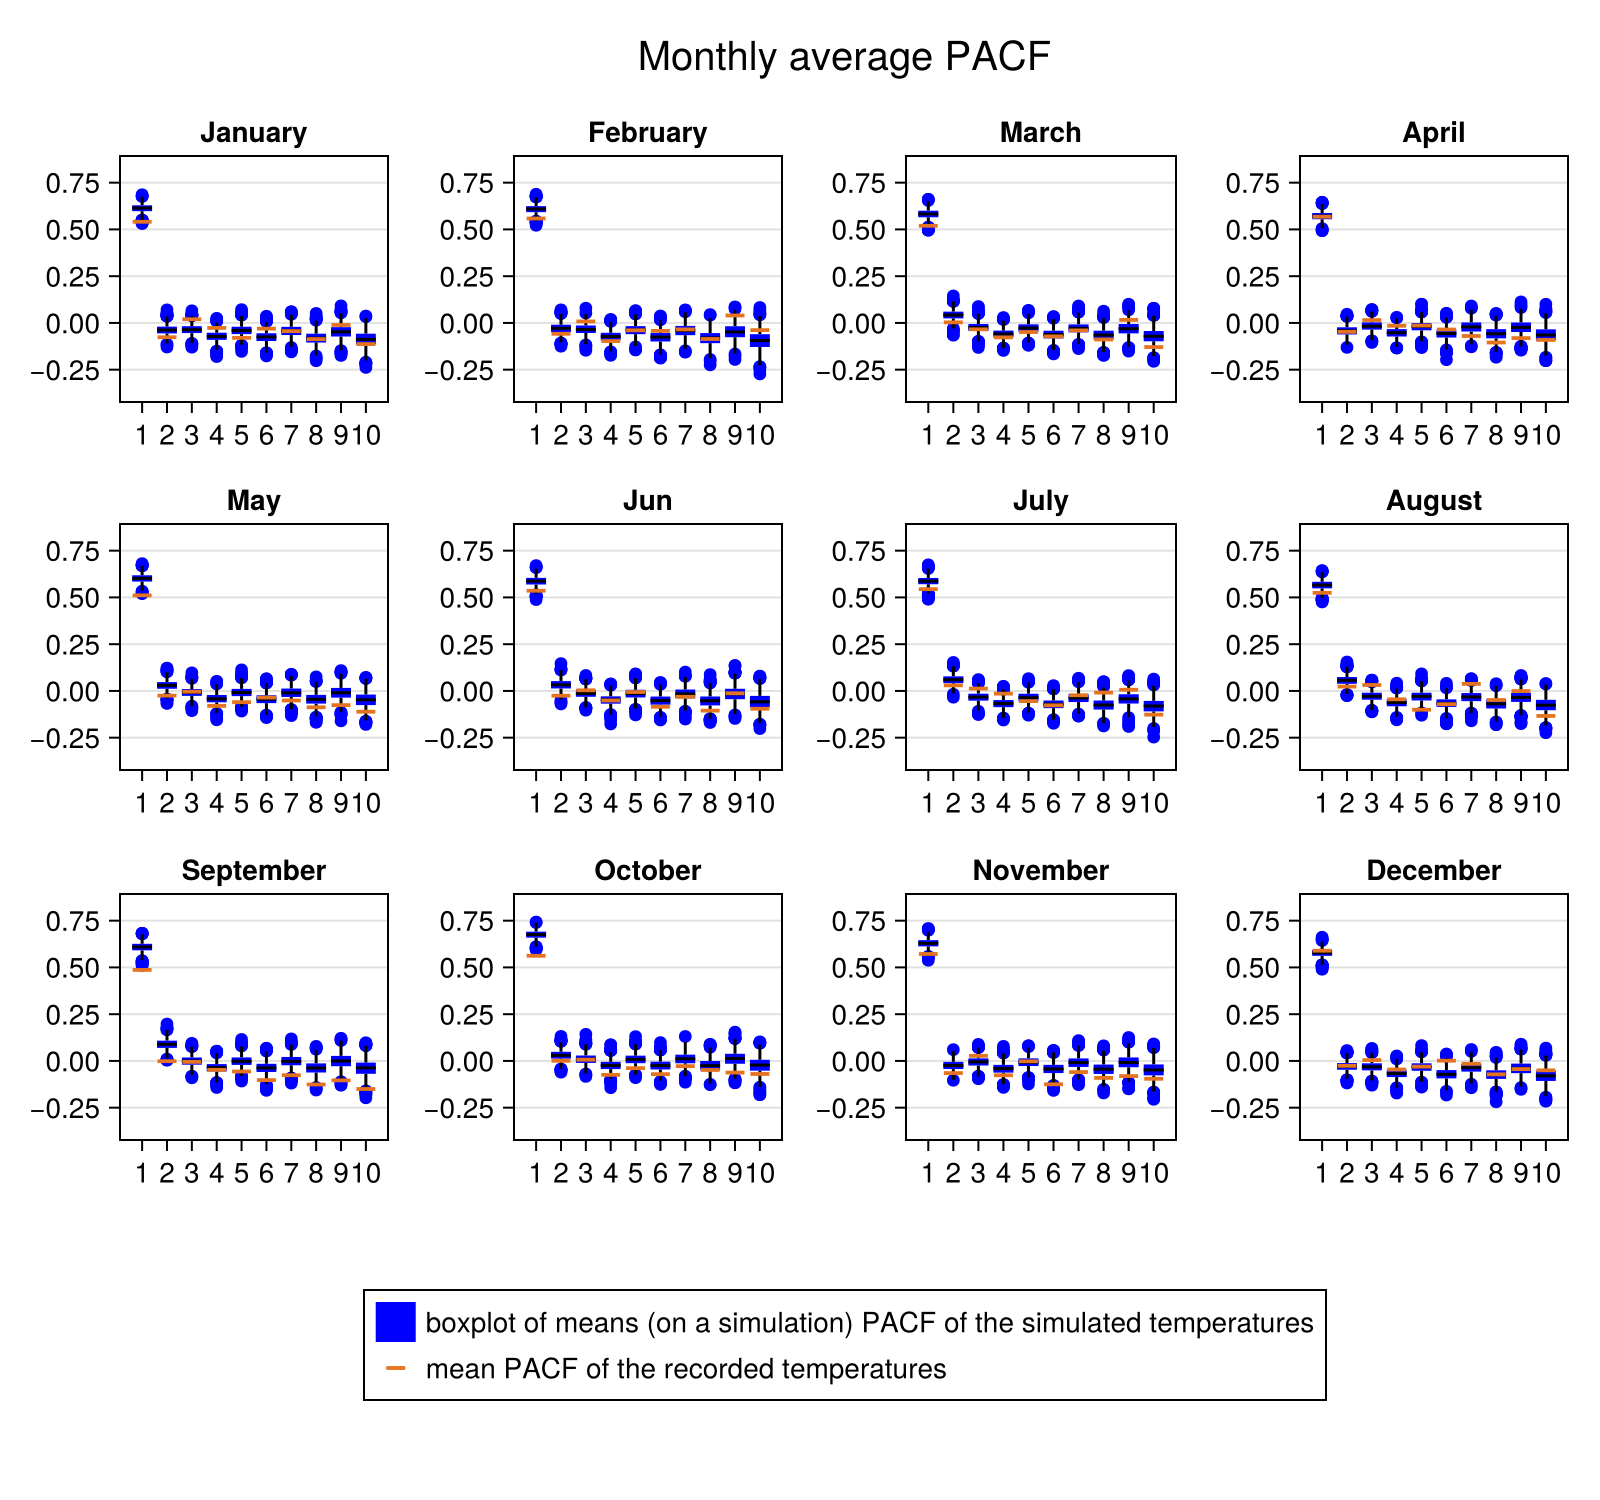

CairoMakie.Screen{IMAGE}


In [30]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"monthlyLL")
sample_ = SimulateScenarios(Monthly_temp[1][1][1:2],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=2000)
year_sample = GatherYearScenarios(sample_,series.DATE[1]:series.DATE[end])
# display(PlotYearCurves([period,mean.(year_sample)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
# display(PlotYearCurves([period,avg_day,max_day],
# ["Periodicity estimation","Average recorded temperatures","Maximum recorded temperatures","Simulated temperatures range","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
# "Average daily temperature during a year (centered)",
# [(minimum.(year_sample),maximum.(year_sample)),(quantile.(year_sample,0.25),quantile.(year_sample,0.75))],
# [("#009bff",0.2),("#009bff",0.5)],
# colors=["blue","orange","red"]
# ))
# display(PlotYearCurves([maximum.(year_sample) .- minimum.(year_sample) , quantile.(year_sample,0.75) .- quantile.(year_sample,0.25)],
# ["Simulated temperatures range" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
# "Simulated temperatures interquartile range"
# ))
# display.(WrapPlotMonthlyStats(df_month, sample_, series.DATE[1]:series.DATE[end]))
display(Plot_Sample_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))
display(Plot_Sample_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

In [31]:
mean(Error_MonthlyACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp))

0.04781947216697726

In [ ]:
MPACF=Error_MonthlyPACF(sample_,series.DATE[1]:series.DATE[end],Monthly_temp)
display(mean(MPACF[1,:]))
display(mean(MPACF[2,:]))